In [1]:
import numpy as np
import torch
from torchvision import datasets, transforms
import time
import cv2


In [2]:

!git clone https://github.com/shhommychon/mnist_generative_practice.git

import sys
sys.path = ["./mnist_generative_practice"] + sys.path

Cloning into 'mnist_generative_practice'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 35 (delta 12), reused 30 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (35/35), 1.60 MiB | 4.16 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [3]:
!apt install megatools

# mnist_feature_extractor.dth
!megadl 'https://mega.nz/file/DgUQyDyB#7Gyq_9kzCz8FcGZV659VD1Cq1_36wimGVOG2Eram3P8'

# mnist_classifier.dth
!megadl 'https://mega.nz/file/H49S3bTI#qsonzlkV3JMniTbyzV77BB9VLhwmh1OJLTgxuD4PEMM'

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  megatools
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 207 kB of archives.
After this operation, 898 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 megatools amd64 1.10.3-1build1 [207 kB]
Fetched 207 kB in 0s (442 kB/s)
Selecting previously unselected package megatools.
(Reading database ... 123629 files and directories currently installed.)
Preparing to unpack .../megatools_1.10.3-1build1_amd64.deb ...
Unpacking megatools (1.10.3-1build1) ...
Setting up megatools (1.10.3-1build1) ...
Processing triggers for man-db (2.10.2-1) ...
Downloaded mnist_feature_extractor.dth
Downloaded mnist_classifier.dth


In [4]:

!apt install megatools

# mnist_diffusion.dth
!megadl 'https://mega.nz/file/Sg90lRhQ#LBZAwdB26Il-cqFYs7Q-WpX7AOWwRl2a1OlQ2vXK9J4'

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
megatools is already the newest version (1.10.3-1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Downloaded mnist_diffusion.dth


In [5]:
def zernfun(n, m, r, theta, nflag=None):
    """
    Zernike functions of order N and frequency M on the unit circle.
    """
    import numpy as np
    from math import factorial

    # Input validation
    if not (np.ndim(n) == 1 and np.ndim(m) == 1):
        raise ValueError('N and M must be vectors.')

    if len(n) != len(m):
        raise ValueError('N and M must be the same length.')

    n = np.array(n).flatten()
    m = np.array(m).flatten()

    if np.any((n - m) % 2 != 0):
        raise ValueError('All N and M must differ by multiples of 2 (including 0).')

    if np.any(m > n):
        raise ValueError('Each M must be less than or equal to its corresponding N.')

    if np.any((r > 1) | (r < 0)):
        raise ValueError('All R must be between 0 and 1.')

    if not (np.ndim(r) == 1 and np.ndim(theta) == 1):
        raise ValueError('R and THETA must be vectors.')

    r = np.array(r).flatten()
    theta = np.array(theta).flatten()
    length_r = len(r)
    if length_r != len(theta):
        raise ValueError('The number of R- and THETA-values must be equal.')

    # Check normalization
    if nflag is not None and isinstance(nflag, str):
        isnorm = nflag.lower() == 'norm'
        if not isnorm and nflag != '':
            raise ValueError('Unrecognized normalization flag.')
    else:
        isnorm = False

    # Compute the Zernike polynomials
    m_abs = np.abs(m)
    rpowers = []
    for j in range(len(n)):
        rpowers.extend(range(int(m_abs[j]), int(n[j]) + 1, 2))
    rpowers = np.unique(rpowers)

    # Pre-compute the values of r raised to the required powers
    rpowern = np.zeros((length_r, len(rpowers)))
    for idx, p in enumerate(rpowers):
        rpowern[:, idx] = r ** p

    # Compute the values of the polynomials
    z = np.zeros((length_r, len(n)))
    for j in range(len(n)):
        n_j = int(n[j])
        m_abs_j = int(m_abs[j])
        s_max = (n_j - m_abs_j) // 2
        s = np.arange(0, s_max + 1)
        pows = np.arange(n_j, m_abs_j - 1, -2)
        for k in range(len(s)):
            s_k = int(s[k])
            pow_k = int(pows[k])
            numerator = (-1) ** s_k * factorial(n_j - s_k)
            denominator = (factorial(s_k) *
                           factorial((n_j + m_abs_j) // 2 - s_k) *
                           factorial((n_j - m_abs_j) // 2 - s_k))
            p = numerator / denominator
            idx_rpow = np.where(rpowers == pow_k)[0][0]
            z[:, j] += p * rpowern[:, idx_rpow]

        if isnorm:
            z[:, j] *= np.sqrt((1 + (m[j] != 0)) * (n[j] + 1) / np.pi)

    # Compute the Zernike functions
    idx_pos = m > 0
    idx_neg = m < 0

    if np.any(idx_pos):
        z[:, idx_pos] *= np.cos(theta[:, np.newaxis] * m_abs[idx_pos])
    if np.any(idx_neg):
        z[:, idx_neg] *= np.sin(theta[:, np.newaxis] * m_abs[idx_neg])

    return z


In [6]:
def gen_aberration(NA_mask, N_NA, max_value, Max_N):
    """
    Generate aberration phase map and coefficients
    """
    import numpy as np
    k_index = np.nonzero(NA_mask)
    N_img = NA_mask.shape[0]

    kx, ky = np.meshgrid(np.arange(1, N_img + 1), np.arange(1, N_img + 1))
    kc = np.mean(kx)
    kx = kx.astype(float) - kc
    ky = ky.astype(float) - kc
    kx = kx / float(N_NA)
    ky = ky / float(N_NA)
    kx = kx[k_index]
    ky = ky[k_index]

    N_z = []
    M_z = []
    for n in range(0, Max_N + 1):
        N_z.extend([n] * (n + 1))
        M_z.extend(range(-n, n + 1, 2))

    N_z = np.array(N_z)
    M_z = np.array(M_z)
    theta, rho = np.arctan2(ky, kx), np.hypot(kx, ky)
    z = zernfun(N_z, M_z, rho, theta)
    j_max = z.shape[1]

    z_norm = np.sum(z * z, axis=0)
    for j in range(j_max):
        if M_z[j] == 0:
            epsilon = 2
        else:
            epsilon = 1
        z_norm[j] = z_norm[j] * (2 * N_z[j] + 2) / (epsilon * np.pi)
    z_norm = np.sqrt(z_norm)

    linear_coeff = -max_value * (N_z - Max_N - 1).astype(float) / float(Max_N)
    z_coefficients = linear_coeff * (np.random.rand(j_max) - 0.5)

    z_coefficients[0] = 0  # DC offset

    tmp_map = np.sum(z * (z_coefficients / z_norm), axis=1)
    phase_map = np.zeros((N_img, N_img))
    phase_map[k_index] = tmp_map
    phase_map = (phase_map + np.pi) % (2 * np.pi) - np.pi

    return phase_map, z_coefficients


In [7]:
# [00] Data options
full_opt = 1  # 1600(1), 1264(0)
basis = 'kx'  # kk, kx, rr

target_opt = 'lm'

abin_cpx = 'non'  # rand, non, exrand, (fix)
about_cpx = 'non'
about_fact = 10
abin_fact = 10

comp_opt = 'reim'  # angle, reim

sc_opt = 1  # scattering off(0)/on(1)
MS = 10
SM = 1 / MS  # single/multi intensity ratio

# [0] Parameters setup

NAsz = 20  # radius of pupil [pixel] corresponding to koNA, 21 for 0.4NA 40um FoV (L/dx)
matsz = 4 * NAsz  # [pixel] corresponding to 4*koNA w/ Kpadding

lamb = 0.8  # wavelength [um]
dx = lamb / 0.4 / 2  # NA resolution, 2pi/(2koNA) [um] *2 for 0.2NA
xtick = dx * np.arange(1, matsz + 1) / 2  # tick in x-space, /2 for 2koNA(radius) matrix (Kpadded)
xtick = xtick - np.mean(xtick)

dk = 2 * 2 * np.pi / dx  # maximum k radius, 2*koNA [/um]  2* for K padding (=4*koNA diameter)
ktick = dk / matsz * np.arange(1, matsz + 1)  # tick in k-space
ktick = ktick - np.mean(ktick)

xx, yy = np.meshgrid(np.arange(1, matsz + 1), np.arange(1, matsz + 1))
rr = (xx - np.mean(xx)) + 1j * (yy - np.mean(yy))

cmask = np.sqrt((xx - np.mean(xx)) ** 2 + (yy - np.mean(yy)) ** 2) / NAsz
cmask[cmask <= 1] = 1
cmask[cmask > 1] = 0

if full_opt == 1:
    nzind = np.arange(0, (2 * NAsz) ** 2)
else:
    cmask_crop = cmask[NAsz:3 * NAsz, NAsz:3 * NAsz]
    nzind = np.nonzero(cmask_crop)


In [8]:
# Load MNIST dataset
mnist_testset = datasets.MNIST(root='./data', train=False, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))

# Get an image
img, label = mnist_testset[5002]  # Indexing from 0, so 5002 corresponds to 5003rd image
tmp = img.squeeze().numpy()  # Get a numpy array of shape (28,28)

# Pad or resize the image
if target_opt == 'sm':
    pad_amount = int(2 * NAsz - tmp.shape[0] / 2)  # Should be 26
    tobj = np.pad(tmp, pad_amount, mode='constant', constant_values=0)
elif target_opt == 'lm':
    # Resize the image to 80x80
    tobj = cv2.resize(tmp, (80, 80))


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 491kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.40MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.40MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [9]:
start_time = time.time()

if comp_opt == 'reim':
    data_mat = np.zeros((2 * NAsz, 2 * NAsz, len(nzind) * 2))
    truth_mat = np.zeros((2 * NAsz, 2 * NAsz, 4))

# Prepare xin-kout (if basis is 'kx')
if basis == 'kx':
    xinkout = np.zeros(((2 * NAsz) ** 2, (2 * NAsz) ** 2), dtype=complex)
    for ii in range((2 * NAsz) ** 2):
        xin = np.zeros((2 * NAsz, 2 * NAsz), dtype=complex)
        xin.flat[ii] = 1
        tmp = np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(xin)))
        xinkout[:, ii] = tmp.flatten()

# Continue with the rest of the computation
xx, yy = np.meshgrid(np.arange(1, 4 * NAsz + 1), np.arange(1, 4 * NAsz + 1))
re = 2
cmask2 = np.sqrt((xx - np.mean(xx)) ** 2 + (yy - np.mean(yy)) ** 2) / (re * NAsz)
cmask2[cmask2 <= 1] = 1
cmask2[cmask2 > 1] = 0

target = np.fft.fftshift(np.fft.fft2(tobj))
# target = target * cmask2  # Uncomment if needed

ktarget = target * cmask  # r=40 mask
ktarget = ktarget[NAsz:3 * NAsz, NAsz:3 * NAsz]

xtarget = np.fft.ifft2(np.fft.ifftshift(target))

# Generate kin-kout matrix
kxtmp, kytmp = np.meshgrid(np.arange(-NAsz, NAsz), np.arange(-NAsz, NAsz))
kx = kxtmp.flatten()
ky = kytmp.flatten()
n1 = (2 * NAsz) ** 2

Smat = np.zeros((n1, n1), dtype=complex)

for ii in range(n1):
    tmp = np.roll(np.roll(target, int(kx[ii]), axis=0), int(ky[ii]), axis=1) * cmask
    tmp = tmp[NAsz:3 * NAsz, NAsz:3 * NAsz]
    Smat[:, ii] = tmp.flatten()


In [10]:
# Create input/output pupil function matrix
sz = 2 * NAsz
kx2, ky2 = np.meshgrid(np.arange(1, sz + 1), np.arange(1, sz + 1))
kc = 20.5  # sz / 2 + 1
NA_mask = (kx2 - kc) ** 2 + (ky2 - kc) ** 2 < NAsz ** 2
roi_NA = np.arange(kc - NAsz, kc + NAsz)
k_index = np.nonzero(NA_mask)

ipf = np.zeros((2 * NAsz, 2 * NAsz), dtype=complex)

if abin_cpx == 'rand':
    abin_fact = 10 + 50 * np.random.rand()  # degree of aberration (10~60)

ab_phase_map, z_coeff = gen_aberration(NA_mask, NAsz, 50, int(abin_fact))

if abin_cpx == 'exrand':
    ab_phase_map = 2 * 3.14 * np.random.rand(40, 40) - 3.14
elif abin_cpx == 'ramp':
    ramp = np.zeros((40, 40))
    for i in range(40):
        ramp[i, :] = -np.pi + i * np.pi / 40
    ab_phase_map = ramp

ipf[k_index] = np.exp(1j * ab_phase_map[k_index])

if abin_cpx == 'non':
    ipf[NA_mask] = 1.0  # no aberration

# Similarly for opf
opf = np.zeros((2 * NAsz, 2 * NAsz), dtype=complex)

if about_cpx == 'rand':
    about_fact = 10 + 50 * np.random.rand()  # degree of aberration (10~60)

ab_phase_map_opf, z_coeff_opf = gen_aberration(NA_mask, NAsz, 50, int(about_fact))

if about_cpx == 'exrand':
    ab_phase_map_opf = 2 * 3.14 * np.random.rand(40, 40) - 3.14
elif about_cpx == 'ramp':
    ramp = np.zeros((40, 40))
    for i in range(40):
        ramp[i, :] = -np.pi + i * np.pi / 40
    ab_phase_map_opf = ramp

opf[k_index] = np.exp(1j * ab_phase_map_opf[k_index])

if about_cpx == 'non':
    opf[NA_mask] = 1.0  # no aberration

# Apply pupil functions
ipf_flat = ipf.flatten()
opf_flat = opf.flatten()

Smat = (opf_flat[:, np.newaxis]) * Smat * (ipf_flat[np.newaxis, :])


In [11]:
kxmat = Smat
kxmat = kxmat[:, nzind]

if basis == 'kx':
    kxmat = kxmat @ xinkout

if basis == 'rr':
    kxmat = kxmat @ kxmat.T

rimat = np.zeros((40, 40, len(nzind) * 2))
trmat = np.zeros((40, 40, truth_mat.shape[2]))

if basis == 'rr':
   abin_tmp = np.conj(opf)
else:
   abin_tmp = ipf
about_tmp = opf

if sc_opt == 1:
    chan = kxmat.shape[0]
    Mmat = np.random.randn(chan, chan) + 1j * np.random.randn(chan, chan)

    IM = np.mean(np.sum(np.abs(Mmat) ** 2))
    IS = np.mean(np.sum(np.abs(kxmat) ** 2))

    mat = kxmat * np.sqrt(IM / IS * SM) + Mmat
    kxmat = mat[:, nzind]
else:
    kxmat = kxmat[:, nzind]

rimat[:, :, 0::2] = np.real(kxmat).reshape(40, 40, -1)
rimat[:, :, 1::2] = np.imag(kxmat).reshape(40, 40, -1)

trmat[:, :, 0] = np.real(about_tmp).reshape(40, 40)
trmat[:, :, 1] = np.imag(about_tmp).reshape(40, 40)
trmat[:, :, 2] = np.real(abin_tmp).reshape(40, 40)
trmat[:, :, 3] = np.imag(abin_tmp).reshape(40, 40)

data_mat = rimat
truth_mat = trmat

end_time = time.time()
print("Time taken:", end_time - start_time)


Time taken: 1.7556729316711426


In [12]:
import os

if full_opt == 1:
    matloc = f'test_data/{basis}_full/{target_opt}/{about_cpx}/'
else:
    matloc = f'test_data/{basis}/{target_opt}/{about_cpx}/'

if not os.path.exists(matloc):
    os.makedirs(matloc)

dataloc = os.path.join(matloc, 'data_mat.npy')
truthloc = os.path.join(matloc, 'truth_mat.npy')

np.save(dataloc, data_mat)
np.save(truthloc, truth_mat)

print("Data saved.")


Data saved.


Data and truth matrices loaded.


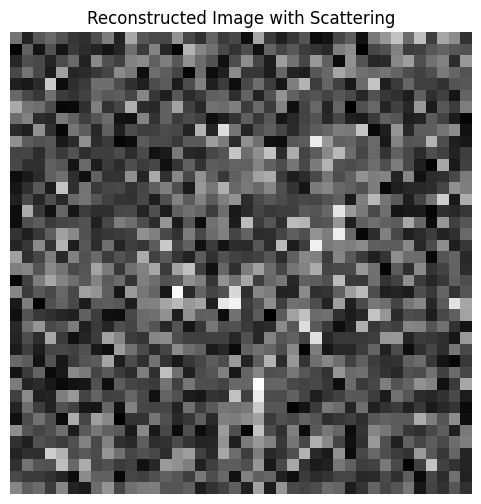

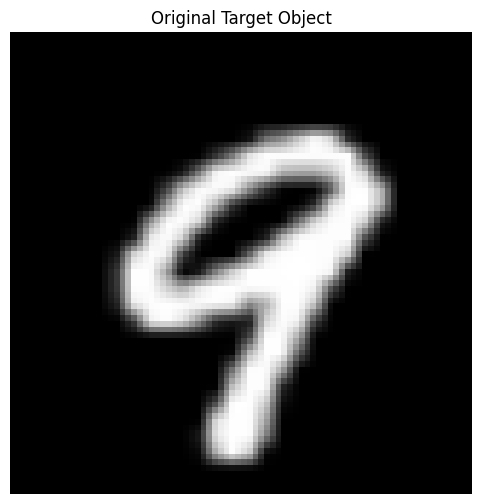

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Load the data
if full_opt == 1:
    matloc = f'test_data/{basis}_full/{target_opt}/{about_cpx}/'
else:
    matloc = f'test_data/{basis}/{target_opt}/{about_cpx}/'

dataloc = os.path.join(matloc, 'data_mat.npy')
truthloc = os.path.join(matloc, 'truth_mat.npy')

# Load the numpy arrays
data_mat = np.load(dataloc)
truth_mat = np.load(truthloc)

print("Data and truth matrices loaded.")

# Assuming that data_mat contains the complex data for the image
# Reconstruct the complex data from real and imaginary parts
num_channels = data_mat.shape[2] // 2  # Number of complex channels

# For simplicity, let's assume we can sum over all channels to reconstruct the image
# Alternatively, select specific channels that correspond to the image data

# Initialize an empty array for the complex image
complex_image = np.zeros((data_mat.shape[0], data_mat.shape[1]), dtype=complex)

# Sum over all channels to get the combined complex image
for i in range(num_channels):
    real_part = data_mat[:, :, 2 * i]
    imag_part = data_mat[:, :, 2 * i + 1]
    complex_channel = real_part + 1j * imag_part
    complex_image += complex_channel  # Summing over channels

# Perform inverse transformation to get back to spatial domain
# Since the data might be in Fourier space, use inverse FFT
reconstructed_image = np.fft.ifft2(complex_image)

# Take the magnitude to get the real-valued image
reconstructed_magnitude = np.abs(reconstructed_image)

# Normalize the reconstructed image for visualization
reconstructed_magnitude /= np.max(reconstructed_magnitude)

# Visualize the reconstructed image
plt.figure(figsize=(6, 6))
plt.imshow(reconstructed_magnitude, cmap='gray')
plt.title('Reconstructed Image with Scattering')
plt.axis('off')
plt.show()

# Visualize the original target object
plt.figure(figsize=(6, 6))
plt.imshow(tobj, cmap='gray')
plt.title('Original Target Object')
plt.axis('off')
plt.show()


In [14]:
pip install diffusion-models


In [15]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))
mnist_testset = datasets.MNIST(root='./data', train=False, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))

mnist_valset, mnist_testset = torch.utils.data.random_split(
                                mnist_testset,
                                [
                                    int(0.9 * len(mnist_testset)),
                                    int(0.1 * len(mnist_testset))
                                ]
                            )
train_dataloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_valset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(mnist_testset, batch_size=32, shuffle=False)

print("Training dataset size: ", len(mnist_trainset))
print("Validation dataset size: ", len(mnist_valset))
print("Testing dataset size: ", len(mnist_testset))

Training dataset size:  60000
Validation dataset size:  9000
Testing dataset size:  1000


<ipython-input-16-7ec196a3482e>:370: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("mnist_diffusion.dth", map_location=device))


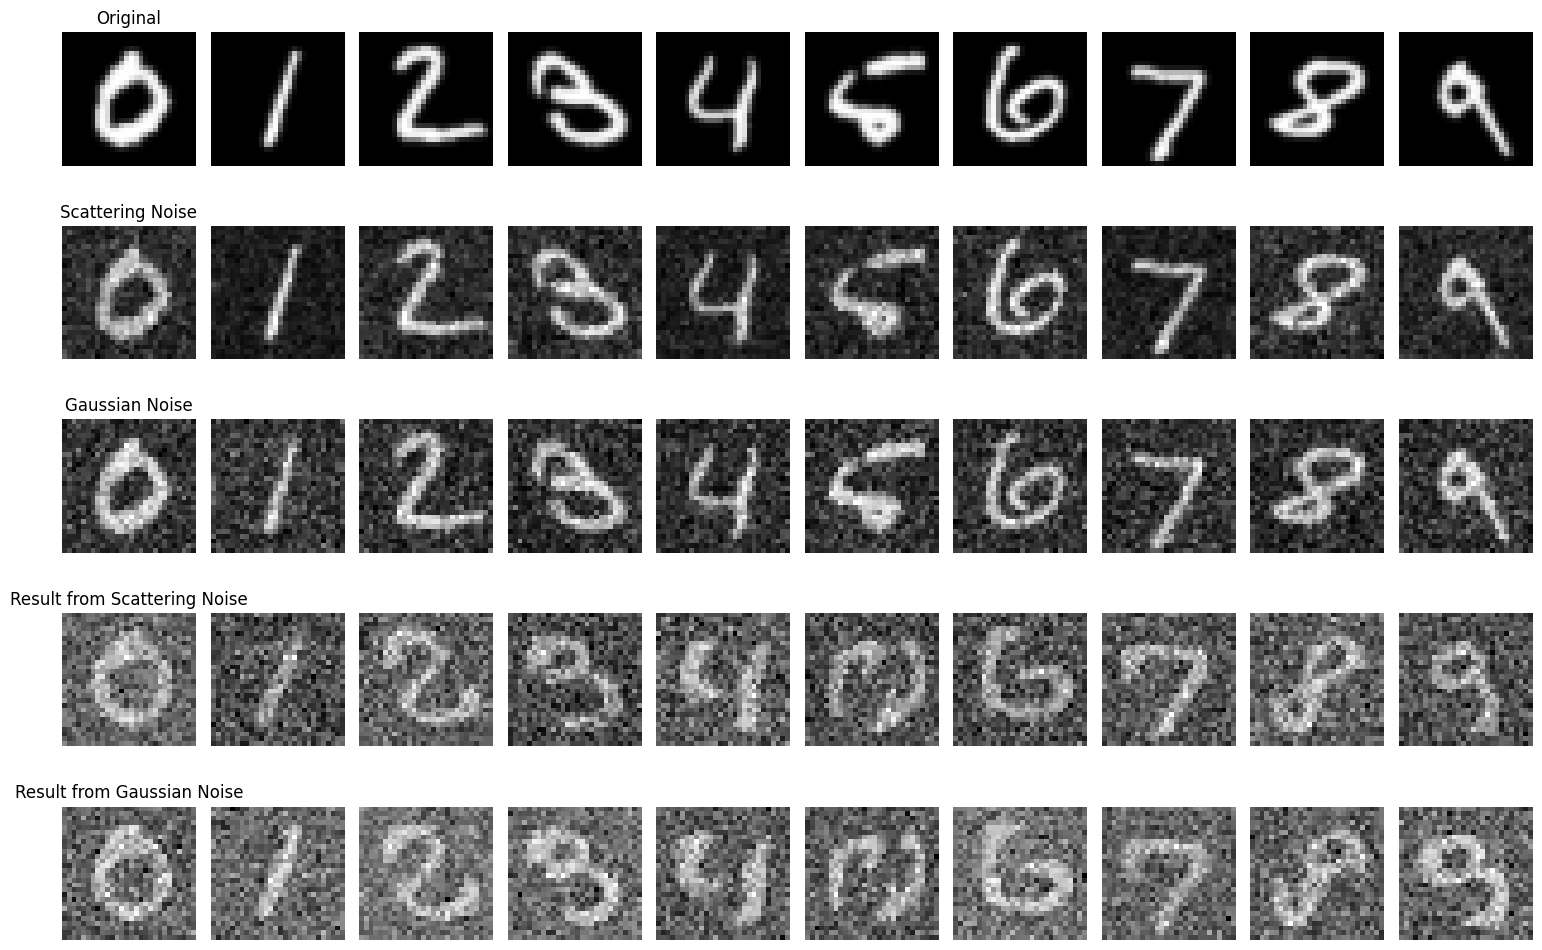

Scattering Noise 결과와 원본의 평균 코사인 유사도: 0.5335
Scattering Noise 결과와 원본의 평균 L2 거리: 9.3674

Gaussian Noise 결과와 원본의 평균 코사인 유사도: 0.5168
Gaussian Noise 결과와 원본의 평균 L2 거리: 9.6417



In [16]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import cv2
import time
from math import factorial

# 필요한 함수들 정의 (zernfun, gen_aberration 등)

def zernfun(n, m, r, theta, nflag=None):
    """
    Zernike functions of order N and frequency M on the unit circle.
    """
    import numpy as np

    # Input validation
    if not (np.ndim(n) == 1 and np.ndim(m) == 1):
        raise ValueError('N and M must be vectors.')

    if len(n) != len(m):
        raise ValueError('N and M must be the same length.')

    n = np.array(n).flatten()
    m = np.array(m).flatten()

    if np.any((n - m) % 2 != 0):
        raise ValueError('All N and M must differ by multiples of 2 (including 0).')

    if np.any(m > n):
        raise ValueError('Each M must be less than or equal to its corresponding N.')

    if np.any((r > 1) | (r < 0)):
        raise ValueError('All R must be between 0 and 1.')

    if not (np.ndim(r) == 1 and np.ndim(theta) == 1):
        raise ValueError('R and THETA must be vectors.')

    r = np.array(r).flatten()
    theta = np.array(theta).flatten()
    length_r = len(r)
    if length_r != len(theta):
        raise ValueError('The number of R- and THETA-values must be equal.')

    # Check normalization
    if nflag is not None and isinstance(nflag, str):
        isnorm = nflag.lower() == 'norm'
        if not isnorm and nflag != '':
            raise ValueError('Unrecognized normalization flag.')
    else:
        isnorm = False

    # Compute the Zernike polynomials
    m_abs = np.abs(m)
    rpowers = []
    for j in range(len(n)):
        rpowers.extend(range(int(m_abs[j]), int(n[j]) + 1, 2))
    rpowers = np.unique(rpowers)

    # Pre-compute the values of r raised to the required powers
    rpowern = np.zeros((length_r, len(rpowers)))
    for idx, p in enumerate(rpowers):
        rpowern[:, idx] = r ** p

    # Compute the values of the polynomials
    z = np.zeros((length_r, len(n)))
    for j in range(len(n)):
        n_j = int(n[j])
        m_abs_j = int(m_abs[j])
        s_max = (n_j - m_abs_j) // 2
        s = np.arange(0, s_max + 1)
        pows = np.arange(n_j, m_abs_j - 1, -2)
        for k in range(len(s)):
            s_k = int(s[k])
            pow_k = int(pows[k])
            numerator = (-1) ** s_k * factorial(n_j - s_k)
            denominator = (factorial(s_k) *
                           factorial((n_j + m_abs_j) // 2 - s_k) *
                           factorial((n_j - m_abs_j) // 2 - s_k))
            p = numerator / denominator
            idx_rpow = np.where(rpowers == pow_k)[0][0]
            z[:, j] += p * rpowern[:, idx_rpow]

        if isnorm:
            z[:, j] *= np.sqrt((1 + (m[j] != 0)) * (n[j] + 1) / np.pi)

    # Compute the Zernike functions
    idx_pos = m > 0
    idx_neg = m < 0

    if np.any(idx_pos):
        z[:, idx_pos] *= np.cos(theta[:, np.newaxis] * m_abs[idx_pos])
    if np.any(idx_neg):
        z[:, idx_neg] *= np.sin(theta[:, np.newaxis] * m_abs[idx_neg])

    return z

def gen_aberration(NA_mask, N_NA, max_value, Max_N):
    """
    Generate aberration phase map and coefficients
    """
    import numpy as np

    k_index = np.nonzero(NA_mask)
    N_img = NA_mask.shape[0]

    kx, ky = np.meshgrid(np.arange(1, N_img + 1), np.arange(1, N_img + 1))
    kc = np.mean(kx)
    kx = kx.astype(float) - kc
    ky = ky.astype(float) - kc
    kx = kx / float(N_NA)
    ky = ky / float(N_NA)
    kx = kx[k_index]
    ky = ky[k_index]

    N_z = []
    M_z = []
    for n in range(0, Max_N + 1):
        N_z.extend([n] * (n + 1))
        M_z.extend(range(-n, n + 1, 2))

    N_z = np.array(N_z)
    M_z = np.array(M_z)
    theta, rho = np.arctan2(ky, kx), np.hypot(kx, ky)
    z = zernfun(N_z, M_z, rho, theta)
    j_max = z.shape[1]

    z_norm = np.sum(z * z, axis=0)
    for j in range(j_max):
        if M_z[j] == 0:
            epsilon = 2
        else:
            epsilon = 1
        z_norm[j] = z_norm[j] * (2 * N_z[j] + 2) / (epsilon * np.pi)
    z_norm = np.sqrt(z_norm)

    linear_coeff = -max_value * (N_z - Max_N - 1).astype(float) / float(Max_N)
    z_coefficients = linear_coeff * (np.random.rand(j_max) - 0.5)

    z_coefficients[0] = 0  # DC offset

    tmp_map = np.sum(z * (z_coefficients / z_norm), axis=1)
    phase_map = np.zeros((N_img, N_img))
    phase_map[k_index] = tmp_map
    phase_map = (phase_map + np.pi) % (2 * np.pi) - np.pi

    return phase_map, z_coefficients

# 스캐터링 노이즈가 추가된 이미지를 저장할 리스트
noisy_images_fourier = []

# 가우시안 노이즈가 추가된 이미지를 저장할 리스트
noisy_images_gaussian = []

# MNIST 데이터셋 로드
mnist_testset = datasets.MNIST(root='./data', train=False, download=True,
                               transform=transforms.Compose([transforms.ToTensor()]))

# 각 숫자(0~9)에 대한 첫 번째 이미지를 가져옵니다.
original_images = [None for _ in range(10)]

for img, label in mnist_testset:
    if original_images[label] is None:
        img_np = img.squeeze().numpy()
        original_images[label] = img_np
    if all(image is not None for image in original_images):
        break

# 이미지를 80x80 크기로 리사이즈합니다.
tobj_list = [cv2.resize(img, (80, 80), interpolation=cv2.INTER_LINEAR) for img in original_images]

# 원본 이미지를 텐서로 변환
original_tensors = [torch.tensor(img_np, dtype=torch.float32).unsqueeze(0) for img_np in tobj_list]

# 각 이미지에 대해 처리
for idx, tobj in enumerate(tobj_list):
    # [00] Data options
    full_opt = 1  # 1600(1), 1264(0)
    basis = 'kx'  # kk, kx, rr

    target_opt = 'lm'

    abin_cpx = 'non'  # rand, non, exrand, (fix)
    about_cpx = 'non'
    about_fact = 10
    abin_fact = 10

    comp_opt = 'reim'  # angle, reim

    sc_opt = 1  # scattering off(0)/on(1)
    MS = 1  # 스캐터링 강도 조절
    SM = 1 / MS  # single/multi intensity ratio

    # [0] Parameters setup

    NAsz = 20  # radius of pupil [pixel]
    matsz = 4 * NAsz  # [pixel]

    lamb = 0.8  # wavelength [um]
    dx = lamb / 0.4 / 2  # NA resolution
    xtick = dx * np.arange(1, matsz + 1) / 2
    xtick = xtick - np.mean(xtick)

    dk = 2 * 2 * np.pi / dx  # maximum k radius
    ktick = dk / matsz * np.arange(1, matsz + 1)
    ktick = ktick - np.mean(ktick)

    xx, yy = np.meshgrid(np.arange(1, matsz + 1), np.arange(1, matsz + 1))
    rr = (xx - np.mean(xx)) + 1j * (yy - np.mean(yy))

    cmask = np.sqrt((xx - np.mean(xx)) ** 2 + (yy - np.mean(yy)) ** 2) / NAsz
    cmask[cmask <= 1] = 1
    cmask[cmask > 1] = 0

    if full_opt == 1:
        nzind = np.arange(0, (2 * NAsz) ** 2)
    else:
        cmask_crop = cmask[NAsz:3 * NAsz, NAsz:3 * NAsz]
        nzind = np.nonzero(cmask_crop)

    if comp_opt == 'reim':
        data_mat = np.zeros((2 * NAsz, 2 * NAsz, len(nzind) * 2))
        truth_mat = np.zeros((2 * NAsz, 2 * NAsz, 4))

    # Prepare xin-kout (if basis is 'kx')
    if basis == 'kx':
        xinkout = np.zeros(((2 * NAsz) ** 2, (2 * NAsz) ** 2), dtype=complex)
        for ii in range((2 * NAsz) ** 2):
            xin = np.zeros((2 * NAsz, 2 * NAsz), dtype=complex)
            xin.flat[ii] = 1
            tmp = np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(xin)))
            xinkout[:, ii] = tmp.flatten()

    # Continue with the rest of the computation
    xx, yy = np.meshgrid(np.arange(1, 4 * NAsz + 1), np.arange(1, 4 * NAsz + 1))
    re = 2
    cmask2 = np.sqrt((xx - np.mean(xx)) ** 2 + (yy - np.mean(yy)) ** 2) / (re * NAsz)
    cmask2[cmask2 <= 1] = 1
    cmask2[cmask2 > 1] = 0

    target = np.fft.fftshift(np.fft.fft2(tobj))

    ktarget = target * cmask  # r=40 mask
    ktarget = ktarget[NAsz:3 * NAsz, NAsz:3 * NAsz]

    xtarget = np.fft.ifft2(np.fft.ifftshift(target))

    # Generate kin-kout matrix
    kxtmp, kytmp = np.meshgrid(np.arange(-NAsz, NAsz), np.arange(-NAsz, NAsz))
    kx = kxtmp.flatten()
    ky = kytmp.flatten()
    n1 = (2 * NAsz) ** 2

    Smat = np.zeros((n1, n1), dtype=complex)

    for ii in range(n1):
        tmp = np.roll(np.roll(target, int(kx[ii]), axis=0), int(ky[ii]), axis=1) * cmask
        tmp = tmp[NAsz:3 * NAsz, NAsz:3 * NAsz]
        Smat[:, ii] = tmp.flatten()

    # Create input/output pupil function matrix
    sz = 2 * NAsz
    kx2, ky2 = np.meshgrid(np.arange(1, sz + 1), np.arange(1, sz + 1))
    kc = NAsz + 0.5  # sz / 2 + 0.5
    NA_mask = (kx2 - kc) ** 2 + (ky2 - kc) ** 2 < NAsz ** 2
    roi_NA = np.arange(kc - NAsz, kc + NAsz)
    k_index = np.nonzero(NA_mask)

    ipf = np.zeros((2 * NAsz, 2 * NAsz), dtype=complex)
    opf = np.zeros((2 * NAsz, 2 * NAsz), dtype=complex)

    # Aberration 설정
    if abin_cpx == 'rand':
        abin_fact = 10 + 50 * np.random.rand()  # degree of aberration (10~60)
        ab_phase_map, z_coeff = gen_aberration(NA_mask, NAsz, 50, int(abin_fact))
        ipf[k_index] = np.exp(1j * ab_phase_map[k_index])
    elif abin_cpx == 'non':
        ipf[NA_mask] = 1.0  # no aberration

    if about_cpx == 'rand':
        about_fact = 10 + 50 * np.random.rand()  # degree of aberration (10~60)
        ab_phase_map_opf, z_coeff_opf = gen_aberration(NA_mask, NAsz, 50, int(about_fact))
        opf[k_index] = np.exp(1j * ab_phase_map_opf[k_index])
    elif about_cpx == 'non':
        opf[NA_mask] = 1.0  # no aberration

    # Apply pupil functions
    ipf_flat = ipf.flatten()
    opf_flat = opf.flatten()

    Smat = (opf_flat[:, np.newaxis]) * Smat * (ipf_flat[np.newaxis, :])

    kxmat = Smat
    kxmat = kxmat[:, nzind]

    if basis == 'kx':
        kxmat = kxmat @ xinkout

    if basis == 'rr':
        kxmat = kxmat @ kxmat.T

    if sc_opt == 1:
        chan = kxmat.shape[0]
        Mmat = np.random.randn(chan, chan) + 1j * np.random.randn(chan, chan)

        IM = np.mean(np.sum(np.abs(Mmat) ** 2))
        IS = np.mean(np.sum(np.abs(kxmat) ** 2))

        mat = kxmat * np.sqrt(IM / IS * SM) + Mmat
        kxmat = mat[:, nzind]
    else:
        kxmat = kxmat[:, nzind]

    # 복소수 데이터 복원
    num_channels = kxmat.shape[1]

    complex_image = np.zeros((2 * NAsz, 2 * NAsz), dtype=complex)

    for i in range(num_channels):
        complex_image += kxmat[:, i].reshape(2 * NAsz, 2 * NAsz)

    # 역변환하여 이미지 복원
    reconstructed_image = np.fft.ifft2(complex_image)

    # 실수부를 취하고 정규화
    reconstructed_magnitude = np.abs(reconstructed_image)
    reconstructed_magnitude /= np.max(reconstructed_magnitude)

    # 스캐터링 노이즈가 추가된 이미지를 저장
    noisy_image_fourier = reconstructed_magnitude.astype(np.float32)
    noisy_images_fourier.append(noisy_image_fourier)

    # 가우시안 노이즈 추가
    def add_gaussian_noise_np(image_np, noise_level=0.5):
        noise = np.random.randn(*image_np.shape) * noise_level
        image_noisy = image_np + noise
        image_noisy = np.clip(image_noisy, 0, 1)
        return image_noisy

    noisy_image_gaussian = add_gaussian_noise_np(tobj)
    noisy_images_gaussian.append(noisy_image_gaussian)

# 이미지 리사이즈 함수 정의
def resize_images(image_list, size=(28, 28)):
    resized_images = []
    for img_np in image_list:
        img_resized = cv2.resize(img_np, size, interpolation=cv2.INTER_AREA)
        resized_images.append(torch.tensor(img_resized, dtype=torch.float32).unsqueeze(0))
    return resized_images

# 이미지들을 리사이즈하고 텐서로 변환
original_tensors = resize_images([img.squeeze().numpy() for img in original_tensors])
noisy_images_fourier_tensors = resize_images(noisy_images_fourier)
noisy_images_gaussian_tensors = resize_images(noisy_images_gaussian)

# 결과를 시각화하기 위해 리스트를 준비
original = original_tensors
noisy_images_fourier = noisy_images_fourier_tensors
noisy_images_gaussian = noisy_images_gaussian_tensors

# 모델 로드 및 설정
from models.diffusion import MNISTDiffusion

device = "cuda" if torch.cuda.is_available() else "cpu"

model = MNISTDiffusion()
model.load_state_dict(torch.load("mnist_diffusion.dth", map_location=device))
model.to(device)
model.eval()

# 레이블 생성
class_label = torch.tensor([n for n in range(10)], dtype=torch.long).to(device)

# 이미지 생성 함수 (모델에 따라 수정 필요)
def generate_images(model, noise, labels, start_step=0):
    model.eval()
    generated_images = noise.clone().to(device)
    with torch.no_grad():
        for t in reversed(range(start_step, model.num_steps)):
            generated_images = model(generated_images, labels, t)
    return generated_images

# 스캐터링 노이즈 이미지로부터 결과 생성
noisy_images_fourier_tensor = torch.stack(noisy_images_fourier).to(device)
result_fourier = generate_images(model, noisy_images_fourier_tensor, class_label).cpu().detach()

# 가우시안 노이즈 이미지로부터 결과 생성
noisy_images_gaussian_tensor = torch.stack(noisy_images_gaussian).to(device)
result_gaussian = generate_images(model, noisy_images_gaussian_tensor, class_label).cpu().detach()

# 결과 시각화
fig, ax = plt.subplots(nrows=5, ncols=10, figsize=(15, 10))

# 원본 이미지 시각화
for i, image in enumerate(original):
    ax[0, i].imshow(image.squeeze(), cmap="gray")
    ax[0, i].axis("off")
    if i == 0:
        ax[0, i].set_title("Original")

# 스캐터링 노이즈 이미지 시각화
for i, image in enumerate(noisy_images_fourier):
    ax[1, i].imshow(image.squeeze(), cmap="gray")
    ax[1, i].axis("off")
    if i == 0:
        ax[1, i].set_title("Scattering Noise")

# 가우시안 노이즈 이미지 시각화
for i, image in enumerate(noisy_images_gaussian):
    ax[2, i].imshow(image.squeeze(), cmap="gray")
    ax[2, i].axis("off")
    if i == 0:
        ax[2, i].set_title("Gaussian Noise")

# 스캐터링 노이즈 이미지로부터 생성된 결과 시각화
for i, image in enumerate(result_fourier):
    ax[3, i].imshow(image.squeeze(), cmap="gray")
    ax[3, i].axis("off")
    if i == 0:
        ax[3, i].set_title("Result from Scattering Noise")

# 가우시안 노이즈 이미지로부터 생성된 결과 시각화
for i, image in enumerate(result_gaussian):
    ax[4, i].imshow(image.squeeze(), cmap="gray")
    ax[4, i].axis("off")
    if i == 0:
        ax[4, i].set_title("Result from Gaussian Noise")

plt.tight_layout()
plt.show()

# 유사도 및 거리 계산 함수
def calculate_similarity_and_distance(original_images, generated_images):
    cos_sim_list = []
    l2_distance_list = []

    for orig_img, gen_img in zip(original_images, generated_images):
        # 이미지를 1차원 벡터로 변환
        orig_vec = orig_img.view(-1)
        gen_vec = gen_img.view(-1)

        # 코사인 유사도 계산
        cos_sim = F.cosine_similarity(orig_vec.unsqueeze(0), gen_vec.unsqueeze(0)).item()
        cos_sim_list.append(cos_sim)

        # L2 거리 계산
        l2_dist = F.pairwise_distance(orig_vec.unsqueeze(0), gen_vec.unsqueeze(0)).item()
        l2_distance_list.append(l2_dist)

    # 평균 값 계산
    avg_cos_sim = np.mean(cos_sim_list)
    avg_l2_dist = np.mean(l2_distance_list)

    return avg_cos_sim, avg_l2_dist

# 원본 이미지를 텐서로 변환
original_tensors = torch.stack([img.clone() for img in original]).to(device)

# 결과에 대해 유사도 및 거리 계산
avg_cos_sim_fourier, avg_l2_dist_fourier = calculate_similarity_and_distance(original_tensors, result_fourier.to(device))
avg_cos_sim_gaussian, avg_l2_dist_gaussian = calculate_similarity_and_distance(original_tensors, result_gaussian.to(device))

print(f"Scattering Noise 결과와 원본의 평균 코사인 유사도: {avg_cos_sim_fourier:.4f}")
print(f"Scattering Noise 결과와 원본의 평균 L2 거리: {avg_l2_dist_fourier:.4f}\n")

print(f"Gaussian Noise 결과와 원본의 평균 코사인 유사도: {avg_cos_sim_gaussian:.4f}")
print(f"Gaussian Noise 결과와 원본의 평균 L2 거리: {avg_l2_dist_gaussian:.4f}\n")


<ipython-input-17-1474b5a37276>:177: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("mnist_diffusion.dth", map_location=device))


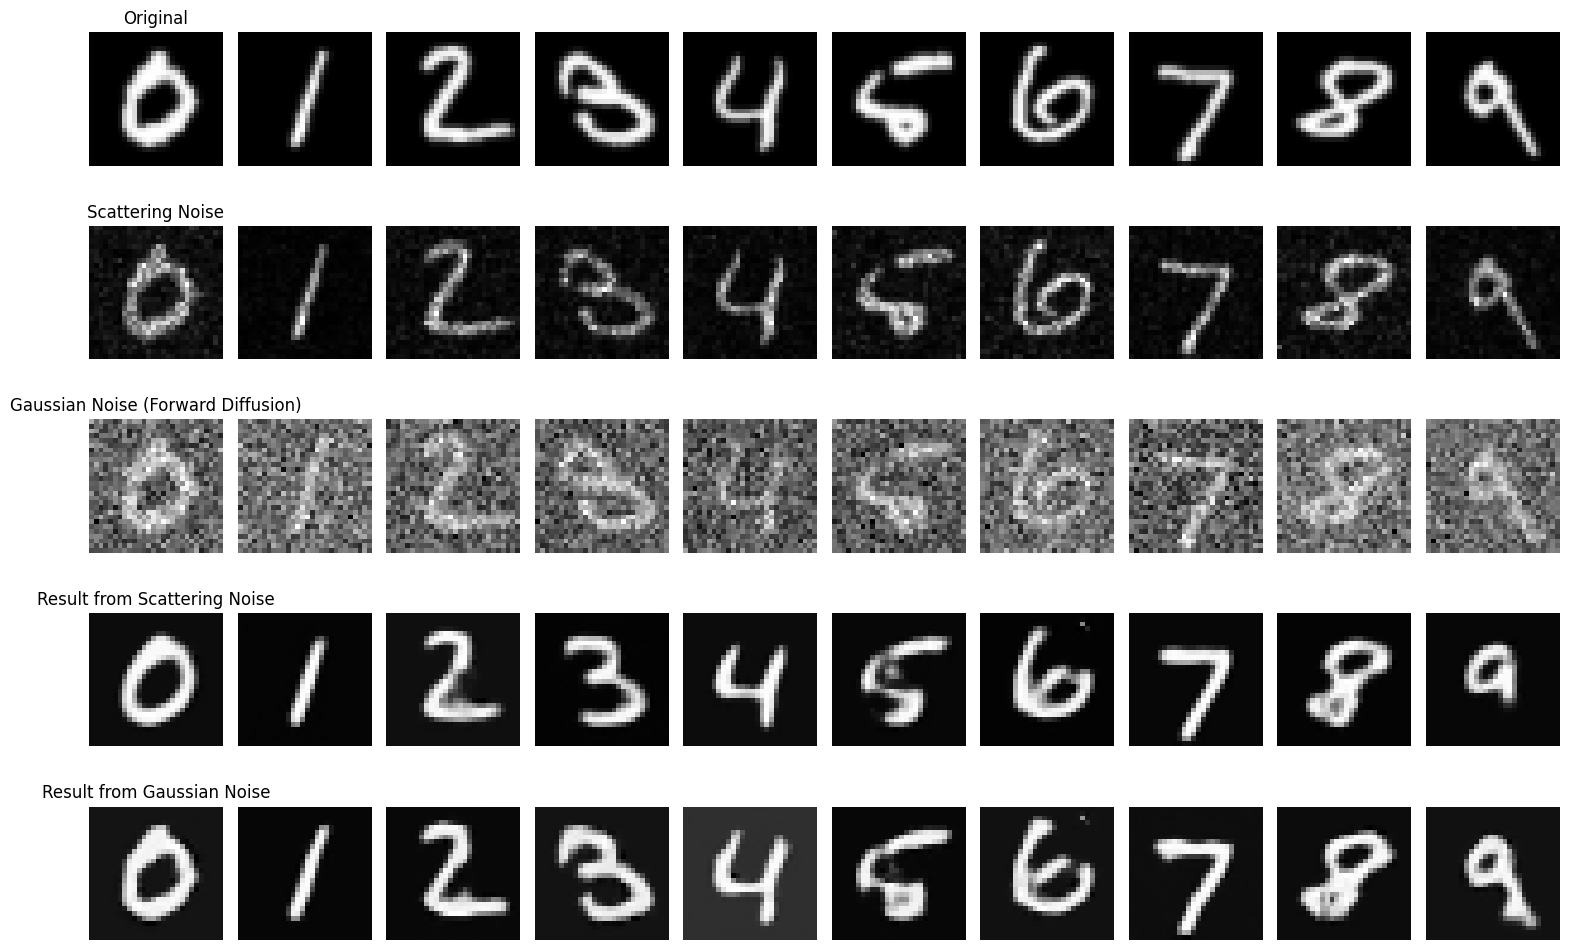

Scattering Noise 결과와 원본의 평균 코사인 유사도: 0.8828
Scattering Noise 결과와 원본의 평균 L2 거리: 4.1098

Gaussian Noise 결과와 원본의 평균 코사인 유사도: 0.9335
Gaussian Noise 결과와 원본의 평균 L2 거리: 3.3903



In [17]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
import cv2
from math import factorial

# 필요한 함수들 정의 (zernfun, gen_aberration 등)

def zernfun(n, m, r, theta, nflag=None):
    """
    Zernike functions of order N and frequency M on the unit circle.
    """
    # Input validation
    if not (np.ndim(n) == 1 and np.ndim(m) == 1):
        raise ValueError('N and M must be vectors.')

    if len(n) != len(m):
        raise ValueError('N and M must be the same length.')

    n = np.array(n).flatten()
    m = np.array(m).flatten()

    if np.any((n - m) % 2 != 0):
        raise ValueError('All N and M must differ by multiples of 2 (including 0).')

    if np.any(m > n):
        raise ValueError('Each M must be less than or equal to its corresponding N.')

    if np.any((r > 1) | (r < 0)):
        raise ValueError('All R must be between 0 and 1.')

    if not (np.ndim(r) == 1 and np.ndim(theta) == 1):
        raise ValueError('R and THETA must be vectors.')

    r = np.array(r).flatten()
    theta = np.array(theta).flatten()
    length_r = len(r)
    if length_r != len(theta):
        raise ValueError('The number of R- and THETA-values must be equal.')

    # Check normalization
    if nflag is not None and isinstance(nflag, str):
        isnorm = nflag.lower() == 'norm'
        if not isnorm and nflag != '':
            raise ValueError('Unrecognized normalization flag.')
    else:
        isnorm = False

    # Compute the Zernike polynomials
    m_abs = np.abs(m)
    rpowers = []
    for j in range(len(n)):
        rpowers.extend(range(int(m_abs[j]), int(n[j]) + 1, 2))
    rpowers = np.unique(rpowers)

    # Pre-compute the values of r raised to the required powers
    rpowern = np.zeros((length_r, len(rpowers)))
    for idx, p in enumerate(rpowers):
        rpowern[:, idx] = r ** p

    # Compute the values of the polynomials
    z = np.zeros((length_r, len(n)))
    for j in range(len(n)):
        n_j = int(n[j])
        m_abs_j = int(m_abs[j])
        s_max = (n_j - m_abs_j) // 2
        s = np.arange(0, s_max + 1)
        pows = np.arange(n_j, m_abs_j - 1, -2)
        for k in range(len(s)):
            s_k = int(s[k])
            pow_k = int(pows[k])
            numerator = (-1) ** s_k * factorial(n_j - s_k)
            denominator = (factorial(s_k) *
                           factorial((n_j + m_abs_j) // 2 - s_k) *
                           factorial((n_j - m_abs_j) // 2 - s_k))
            p = numerator / denominator
            idx_rpow = np.where(rpowers == pow_k)[0][0]
            z[:, j] += p * rpowern[:, idx_rpow]

        if isnorm:
            z[:, j] *= np.sqrt((1 + (m[j] != 0)) * (n[j] + 1) / np.pi)

    # Compute the Zernike functions
    idx_pos = m > 0
    idx_neg = m < 0

    if np.any(idx_pos):
        z[:, idx_pos] *= np.cos(theta[:, np.newaxis] * m_abs[idx_pos])
    if np.any(idx_neg):
        z[:, idx_neg] *= np.sin(theta[:, np.newaxis] * m_abs[idx_neg])

    return z

def gen_aberration(NA_mask, N_NA, max_value, Max_N):
    """
    Generate aberration phase map and coefficients
    """
    k_index = np.nonzero(NA_mask)
    N_img = NA_mask.shape[0]

    kx, ky = np.meshgrid(np.arange(1, N_img + 1), np.arange(1, N_img + 1))
    kc = np.mean(kx)
    kx = kx.astype(float) - kc
    ky = ky.astype(float) - kc
    kx = kx / float(N_NA)
    ky = ky / float(N_NA)
    kx = kx[k_index]
    ky = ky[k_index]

    N_z = []
    M_z = []
    for n in range(0, Max_N + 1):
        N_z.extend([n] * (n + 1))
        M_z.extend(range(-n, n + 1, 2))

    N_z = np.array(N_z)
    M_z = np.array(M_z)
    theta, rho = np.arctan2(ky, kx), np.hypot(kx, ky)
    z = zernfun(N_z, M_z, rho, theta)
    j_max = z.shape[1]

    z_norm = np.sum(z * z, axis=0)
    for j in range(j_max):
        if M_z[j] == 0:
            epsilon = 2
        else:
            epsilon = 1
        z_norm[j] = z_norm[j] * (2 * N_z[j] + 2) / (epsilon * np.pi)
    z_norm = np.sqrt(z_norm)

    linear_coeff = -max_value * (N_z - Max_N - 1).astype(float) / float(Max_N)
    z_coefficients = linear_coeff * (np.random.rand(j_max) - 0.5)

    z_coefficients[0] = 0  # DC offset

    tmp_map = np.sum(z * (z_coefficients / z_norm), axis=1)
    phase_map = np.zeros((N_img, N_img))
    phase_map[k_index] = tmp_map
    phase_map = (phase_map + np.pi) % (2 * np.pi) - np.pi

    return phase_map, z_coefficients

# 스캐터링 노이즈가 추가된 이미지를 저장할 리스트
noisy_images_fourier = []

# 가우시안 노이즈가 추가된 이미지를 저장할 리스트
noisy_images_gaussian = []

# MNIST 데이터셋 로드
mnist_testset = datasets.MNIST(root='./data', train=False, download=True,
                               transform=transforms.Compose([transforms.ToTensor()]))

# 각 숫자(0~9)에 대한 첫 번째 이미지를 가져옵니다.
original_images = [None for _ in range(10)]

for img, label in mnist_testset:
    if original_images[label] is None:
        img_np = img.squeeze().numpy()
        original_images[label] = img_np
    if all(image is not None for image in original_images):
        break

# 이미지를 80x80 크기로 리사이즈합니다.
tobj_list = [cv2.resize(img, (80, 80), interpolation=cv2.INTER_LINEAR) for img in original_images]

# 원본 이미지를 텐서로 변환
original_tensors = [torch.tensor(img_np, dtype=torch.float32).unsqueeze(0) for img_np in tobj_list]

# 모델 로드 및 설정
from models.diffusion import MNISTDiffusion

device = "cuda" if torch.cuda.is_available() else "cpu"

model = MNISTDiffusion()
model.load_state_dict(torch.load("mnist_diffusion.dth", map_location=device))
model.to(device)
model.eval()

# 각 이미지에 대해 처리
for idx, tobj in enumerate(tobj_list):
    # [00] Data options
    full_opt = 1  # 1600(1), 1264(0)
    basis = 'kx'  # kk, kx, rr

    target_opt = 'lm'

    abin_cpx = 'non'  # rand, non, exrand, (fix)
    about_cpx = 'non'
    about_fact = 10
    abin_fact = 10

    comp_opt = 'reim'  # angle, reim

    sc_opt = 1  # scattering off(0)/on(1)
    MS = 1  # 스캐터링 강도 조절
    SM = 1 / MS  # single/multi intensity ratio

    # [0] Parameters setup

    NAsz = 20  # radius of pupil [pixel]
    matsz = 4 * NAsz  # [pixel]

    lamb = 0.8  # wavelength [um]
    dx = lamb / 0.4 / 2  # NA resolution
    xtick = dx * np.arange(1, matsz + 1) / 2
    xtick = xtick - np.mean(xtick)

    dk = 2 * 2 * np.pi / dx  # maximum k radius
    ktick = dk / matsz * np.arange(1, matsz + 1)
    ktick = ktick - np.mean(ktick)

    xx, yy = np.meshgrid(np.arange(1, matsz + 1), np.arange(1, matsz + 1))
    rr = (xx - np.mean(xx)) + 1j * (yy - np.mean(yy))

    cmask = np.sqrt((xx - np.mean(xx)) ** 2 + (yy - np.mean(yy)) ** 2) / NAsz
    cmask[cmask <= 1] = 1
    cmask[cmask > 1] = 0

    if full_opt == 1:
        nzind = np.arange(0, (2 * NAsz) ** 2)
    else:
        cmask_crop = cmask[NAsz:3 * NAsz, NAsz:3 * NAsz]
        nzind = np.nonzero(cmask_crop)

    if comp_opt == 'reim':
        data_mat = np.zeros((2 * NAsz, 2 * NAsz, len(nzind) * 2))
        truth_mat = np.zeros((2 * NAsz, 2 * NAsz, 4))

    # Prepare xin-kout (if basis is 'kx')
    if basis == 'kx':
        xinkout = np.zeros(((2 * NAsz) ** 2, (2 * NAsz) ** 2), dtype=complex)
        for ii in range((2 * NAsz) ** 2):
            xin = np.zeros((2 * NAsz, 2 * NAsz), dtype=complex)
            xin.flat[ii] = 1
            tmp = np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(xin)))
            xinkout[:, ii] = tmp.flatten()

    # Continue with the rest of the computation
    xx, yy = np.meshgrid(np.arange(1, 4 * NAsz + 1), np.arange(1, 4 * NAsz + 1))
    re = 2
    cmask2 = np.sqrt((xx - np.mean(xx)) ** 2 + (yy - np.mean(yy)) ** 2) / (re * NAsz)
    cmask2[cmask2 <= 1] = 1
    cmask2[cmask2 > 1] = 0

    target = np.fft.fftshift(np.fft.fft2(tobj))

    cmask = cmask.astype(bool)

    ktarget = target * cmask  # r=40 mask
    ktarget = ktarget[NAsz:3 * NAsz, NAsz:3 * NAsz]

    xtarget = np.fft.ifft2(np.fft.ifftshift(target))

    # Generate kin-kout matrix
    kxtmp, kytmp = np.meshgrid(np.arange(-NAsz, NAsz), np.arange(-NAsz, NAsz))
    kx = kxtmp.flatten()
    ky = kytmp.flatten()
    n1 = (2 * NAsz) ** 2

    Smat = np.zeros((n1, n1), dtype=complex)

    for ii in range(n1):
        tmp = np.roll(np.roll(target, int(kx[ii]), axis=0), int(ky[ii]), axis=1) * cmask
        tmp = tmp[NAsz:3 * NAsz, NAsz:3 * NAsz]
        Smat[:, ii] = tmp.flatten()

    # Create input/output pupil function matrix
    sz = 2 * NAsz
    kx2, ky2 = np.meshgrid(np.arange(1, sz + 1), np.arange(1, sz + 1))
    kc = NAsz + 0.5  # sz / 2 + 0.5
    NA_mask = (kx2 - kc) ** 2 + (ky2 - kc) ** 2 < NAsz ** 2
    roi_NA = np.arange(kc - NAsz, kc + NAsz)
    k_index = np.nonzero(NA_mask)

    ipf = np.zeros((2 * NAsz, 2 * NAsz), dtype=complex)
    opf = np.zeros((2 * NAsz, 2 * NAsz), dtype=complex)

    # Aberration 설정
    if abin_cpx == 'rand':
        abin_fact = 10 + 50 * np.random.rand()  # degree of aberration (10~60)
        ab_phase_map, z_coeff = gen_aberration(NA_mask, NAsz, 50, int(abin_fact))
        ipf[k_index] = np.exp(1j * ab_phase_map[k_index])
    elif abin_cpx == 'non':
        ipf[NA_mask] = 1.0  # no aberration

    if about_cpx == 'rand':
        about_fact = 10 + 50 * np.random.rand()  # degree of aberration (10~60)
        ab_phase_map_opf, z_coeff_opf = gen_aberration(NA_mask, NAsz, 50, int(about_fact))
        opf[k_index] = np.exp(1j * ab_phase_map_opf[k_index])
    elif about_cpx == 'non':
        opf[NA_mask] = 1.0  # no aberration

    # Apply pupil functions
    ipf_flat = ipf.flatten()
    opf_flat = opf.flatten()

    Smat = (opf_flat[:, np.newaxis]) * Smat * (ipf_flat[np.newaxis, :])

    kxmat = Smat
    kxmat = kxmat[:, nzind]

    if basis == 'kx':
        kxmat = kxmat @ xinkout

    if basis == 'rr':
        kxmat = kxmat @ kxmat.T

    if sc_opt == 1:
        chan = kxmat.shape[0]
        Mmat = np.random.randn(chan, chan) + 1j * np.random.randn(chan, chan)

        IM = np.mean(np.sum(np.abs(Mmat) ** 2))
        IS = np.mean(np.sum(np.abs(kxmat) ** 2))

        mat = kxmat * np.sqrt(IM / IS * SM) + Mmat
        kxmat = mat[:, nzind]
    else:
        kxmat = kxmat[:, nzind]

    # 복소수 데이터 복원
    num_channels = kxmat.shape[1]

    complex_image = np.zeros((2 * NAsz, 2 * NAsz), dtype=complex)

    for i in range(num_channels):
        complex_image += kxmat[:, i].reshape(2 * NAsz, 2 * NAsz)

    # 역변환하여 이미지 복원
    reconstructed_image = np.fft.ifft2(complex_image)

    # 실수부를 취하고 정규화
    reconstructed_magnitude = np.abs(reconstructed_image)**2
    reconstructed_magnitude /= np.max(reconstructed_magnitude)

    # 스캐터링 노이즈가 추가된 이미지를 저장
    noisy_image_fourier = reconstructed_magnitude.astype(np.float32)
    noisy_images_fourier.append(noisy_image_fourier)

    # 가우시안 노이즈 추가 부분 수정: 모델의 Forward Diffusion Process 사용
    # 이미지를 28x28로 리사이즈하고 텐서로 변환
    img_resized = cv2.resize(tobj, (28, 28), interpolation=cv2.INTER_AREA)
    img_tensor = torch.tensor(img_resized, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    # 노이즈 단계 설정 (예: 전체 스텝의 1/3)
    t = 1

    # Forward Diffusion Process를 통해 노이즈 추가
    noisy_image = img_tensor.clone()
    for _ in range(t):
        noisy_image = model(noisy_image, backward=False)

    # 노이즈가 추가된 이미지를 저장
    noisy_images_gaussian.append(noisy_image.cpu().squeeze(0))

# 이미지 리사이즈 함수 정의 (스캐터링 노이즈 이미지에만 적용)
def resize_images(image_list, size=(28, 28)):
    resized_images = []
    for img_np in image_list:
        img_resized = cv2.resize(img_np, size, interpolation=cv2.INTER_AREA)
        resized_images.append(torch.tensor(img_resized, dtype=torch.float32).unsqueeze(0))
    return resized_images

# 스캐터링 노이즈 이미지를 리사이즈하고 텐서로 변환
noisy_images_fourier_tensors = resize_images(noisy_images_fourier)

# 원본 이미지를 리사이즈하고 텐서로 변환
original_tensors = resize_images([img.squeeze().numpy() for img in original_tensors])

# 결과를 시각화하기 위해 리스트를 준비
original = original_tensors
noisy_images_fourier = noisy_images_fourier_tensors

# 가우시안 노이즈 이미지는 이미 텐서로 변환되어 있으므로 그대로 사용
noisy_images_gaussian_tensors = noisy_images_gaussian

# 레이블 생성
class_label = torch.tensor([n for n in range(10)], dtype=torch.long).to(device)

# 이미지 생성 함수 (모델에 따라 수정 필요)
def generate_images(model, noise, labels, start_step=0):
    model.eval()
    generated_images = noise.clone().to(device)
    with torch.no_grad():
        for t in reversed(range(start_step, model.num_steps)):
            generated_images = model(generated_images, labels, t)
    return generated_images

# 스캐터링 노이즈 이미지로부터 결과 생성
noisy_images_fourier_tensor = torch.stack(noisy_images_fourier).to(device)
result_fourier = generate_images(model, noisy_images_fourier_tensor, class_label, start_step = 9).cpu().detach()

# 가우시안 노이즈 이미지로부터 결과 생성 (start_step=t 사용)
noisy_images_gaussian_tensor = torch.stack(noisy_images_gaussian_tensors).to(device)
result_gaussian = generate_images(model, noisy_images_gaussian_tensor, class_label, start_step=model.num_steps - t).cpu().detach()

# 결과 시각화
fig, ax = plt.subplots(nrows=5, ncols=10, figsize=(15, 10))

# 원본 이미지 시각화
for i, image in enumerate(original):
    ax[0, i].imshow(image.squeeze(), cmap="gray")
    ax[0, i].axis("off")
    if i == 0:
        ax[0, i].set_title("Original")

# 스캐터링 노이즈 이미지 시각화
for i, image in enumerate(noisy_images_fourier):
    ax[1, i].imshow(image.squeeze(), cmap="gray")
    ax[1, i].axis("off")
    if i == 0:
        ax[1, i].set_title("Scattering Noise")

# 가우시안 노이즈 이미지 시각화
for i, image in enumerate(noisy_images_gaussian_tensors):
    ax[2, i].imshow(image.squeeze(), cmap="gray")
    ax[2, i].axis("off")
    if i == 0:
        ax[2, i].set_title("Gaussian Noise (Forward Diffusion)")

# 스캐터링 노이즈 이미지로부터 생성된 결과 시각화
for i, image in enumerate(result_fourier):
    ax[3, i].imshow(image.squeeze(), cmap="gray")
    ax[3, i].axis("off")
    if i == 0:
        ax[3, i].set_title("Result from Scattering Noise")

# 가우시안 노이즈 이미지로부터 생성된 결과 시각화
for i, image in enumerate(result_gaussian):
    ax[4, i].imshow(image.squeeze(), cmap="gray")
    ax[4, i].axis("off")
    if i == 0:
        ax[4, i].set_title("Result from Gaussian Noise")

plt.tight_layout()
plt.show()

# 유사도 및 거리 계산 함수
def calculate_similarity_and_distance(original_images, generated_images):
    cos_sim_list = []
    l2_distance_list = []

    for orig_img, gen_img in zip(original_images, generated_images):
        # 이미지를 1차원 벡터로 변환
        orig_vec = orig_img.view(-1)
        gen_vec = gen_img.view(-1)

        # 코사인 유사도 계산
        cos_sim = F.cosine_similarity(orig_vec.unsqueeze(0), gen_vec.unsqueeze(0)).item()
        cos_sim_list.append(cos_sim)

        # L2 거리 계산
        l2_dist = F.pairwise_distance(orig_vec.unsqueeze(0), gen_vec.unsqueeze(0)).item()
        l2_distance_list.append(l2_dist)

    # 평균 값 계산
    avg_cos_sim = np.mean(cos_sim_list)
    avg_l2_dist = np.mean(l2_distance_list)

    return avg_cos_sim, avg_l2_dist

# 원본 이미지를 텐서로 변환
original_tensors = torch.stack([img.clone() for img in original]).to(device)

# 결과에 대해 유사도 및 거리 계산
avg_cos_sim_fourier, avg_l2_dist_fourier = calculate_similarity_and_distance(original_tensors, result_fourier.to(device))
avg_cos_sim_gaussian, avg_l2_dist_gaussian = calculate_similarity_and_distance(original_tensors, result_gaussian.to(device))

print(f"Scattering Noise 결과와 원본의 평균 코사인 유사도: {avg_cos_sim_fourier:.4f}")
print(f"Scattering Noise 결과와 원본의 평균 L2 거리: {avg_l2_dist_fourier:.4f}\n")

print(f"Gaussian Noise 결과와 원본의 평균 코사인 유사도: {avg_cos_sim_gaussian:.4f}")
print(f"Gaussian Noise 결과와 원본의 평균 L2 거리: {avg_l2_dist_gaussian:.4f}\n")


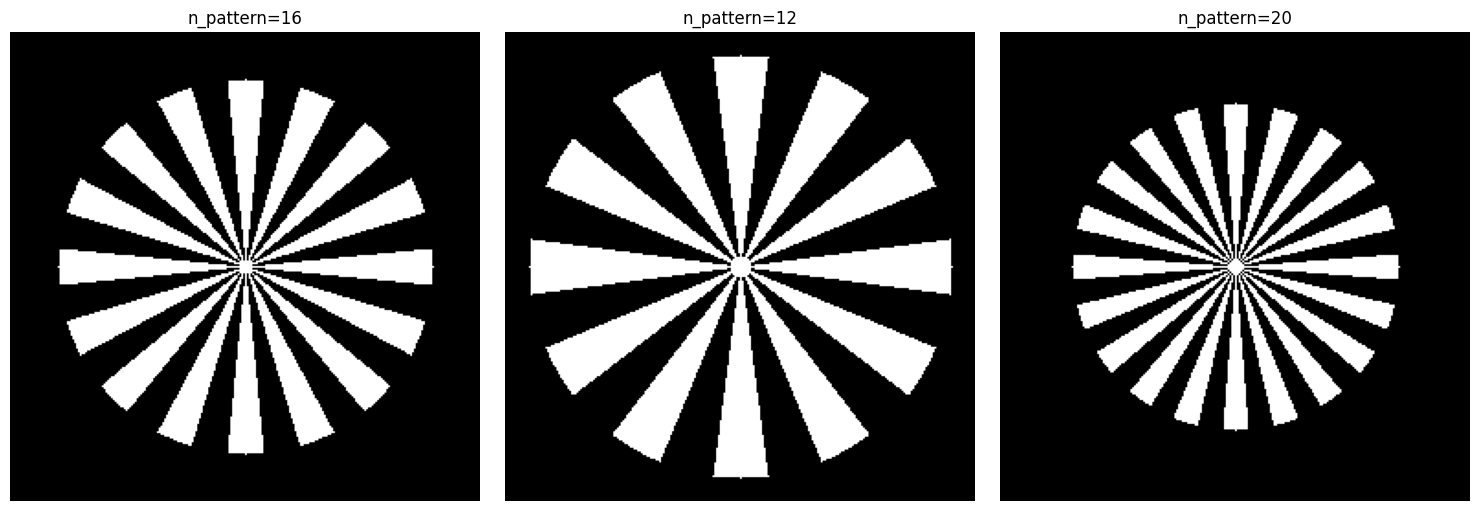

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def siemens(sz, ratio, n_pattern, center_fill=1/30, start_angle=0):
    dtheta = 360 / (2 * n_pattern)
    start_angle = 3 * dtheta / 2

    center = sz // 2
    R_o = ratio * sz // 2
    R_i = center_fill * sz // 2
    theta = np.zeros((sz, sz))

    for x in range(sz):
        for y in range(sz):
            if (y - center) >= 0:
                if (x - center) >= 0:
                    theta[y, x] = np.degrees(np.arctan2((y - center), (x - center)))
                else:
                    theta[y, x] = 180 + np.degrees(np.arctan2((y - center), (x - center)))
            else:
                if (x - center) >= 0:
                    theta[y, x] = 360 + np.degrees(np.arctan2((y - center), (x - center)))
                else:
                    theta[y, x] = 180 + np.degrees(np.arctan2((y - center), (x - center)))

    theta[int(center), int(center)] = 0
    theta = theta + start_angle
    target = np.mod(np.fix(theta / dtheta), 2)

    x, y = np.meshgrid(np.arange(0, sz), np.arange(0, sz))
    target[((x - center) ** 2 + (y - center) ** 2 > R_o ** 2)] = 0
    target[((x - center) ** 2 + (y - center) ** 2 < R_i ** 2)] = 1

    return target

# Generate and visualize sample images
def visualize_siemens_samples():
    samples = [
        {"sz": 256, "ratio": 0.8, "n_pattern": 16, "center_fill": 1/30},
        {"sz": 256, "ratio": 0.9, "n_pattern": 12, "center_fill": 1/20},
        {"sz": 256, "ratio": 0.7, "n_pattern": 20, "center_fill": 1/40},
    ]

    fig, axs = plt.subplots(1, len(samples), figsize=(15, 5))

    for i, params in enumerate(samples):
        img = siemens(**params)
        axs[i].imshow(img, cmap="gray")
        axs[i].set_title(f"n_pattern={params['n_pattern']}")
        axs[i].axis("off")

    plt.tight_layout()
    plt.show()

visualize_siemens_samples()


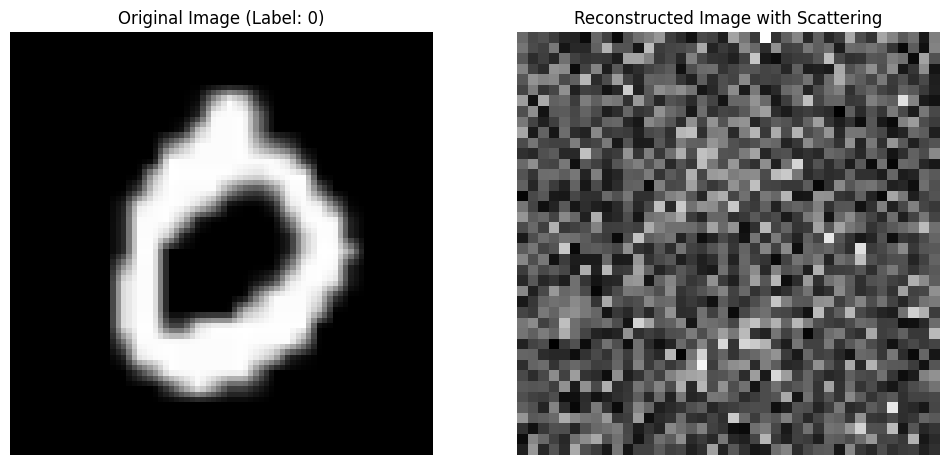

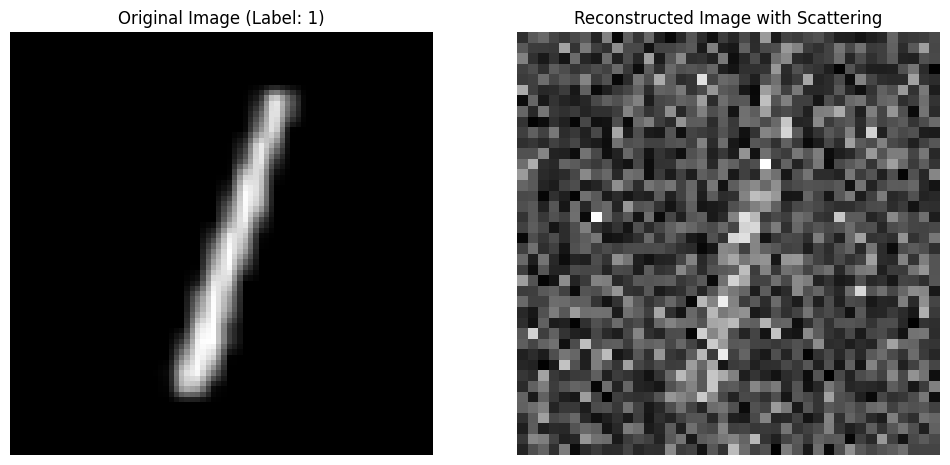

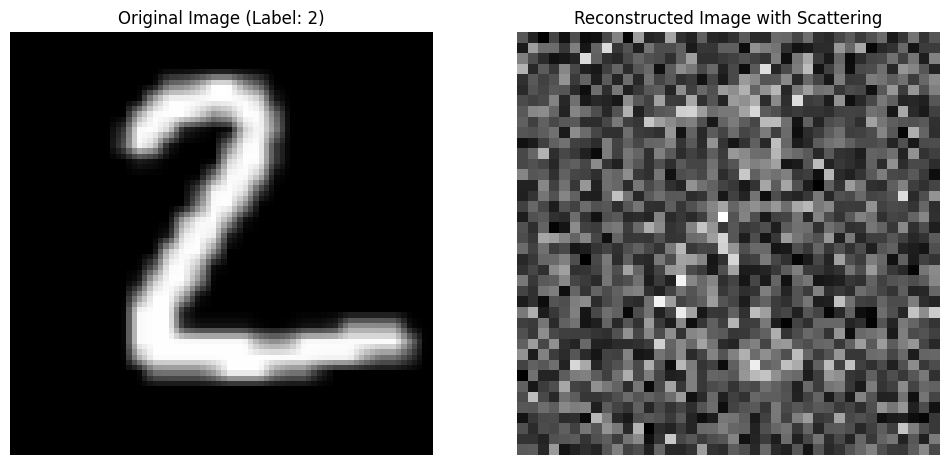

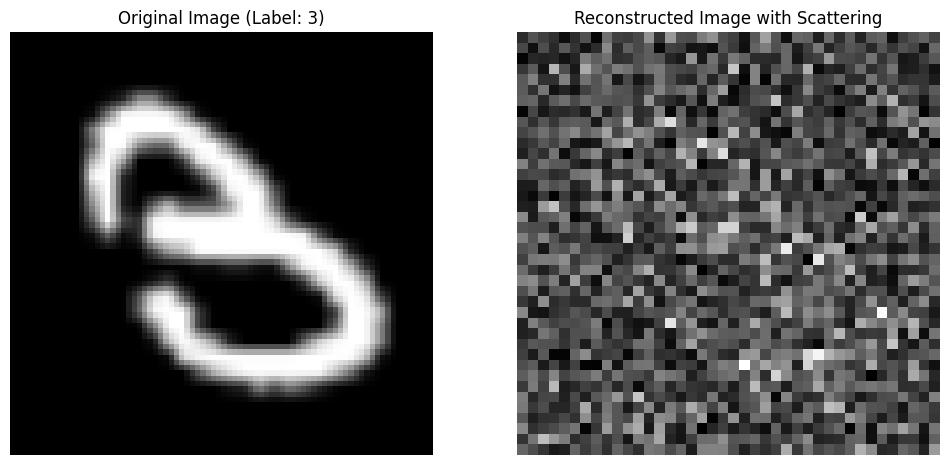

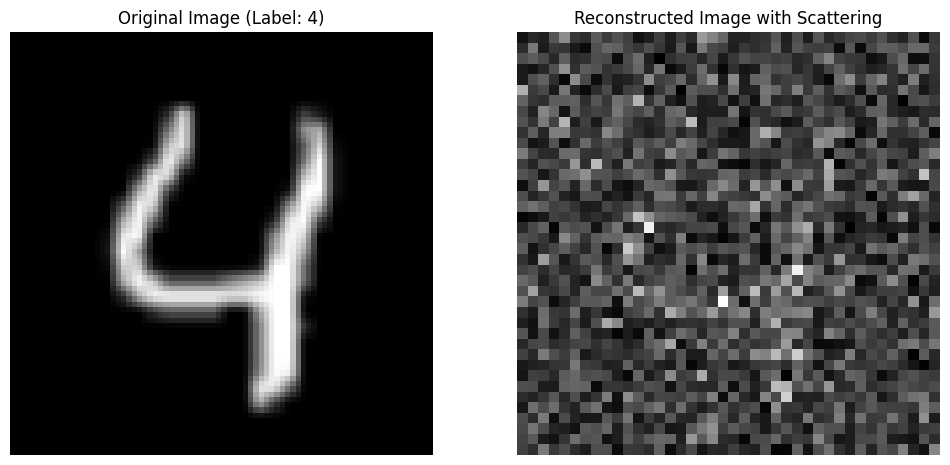

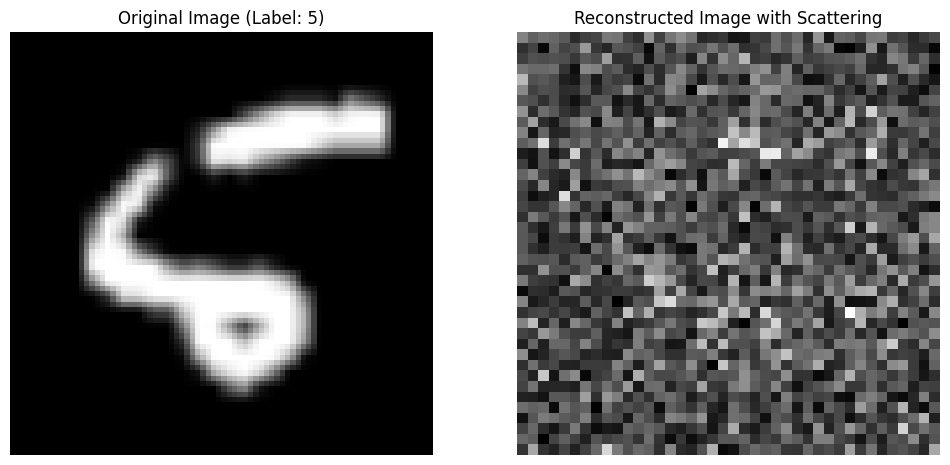

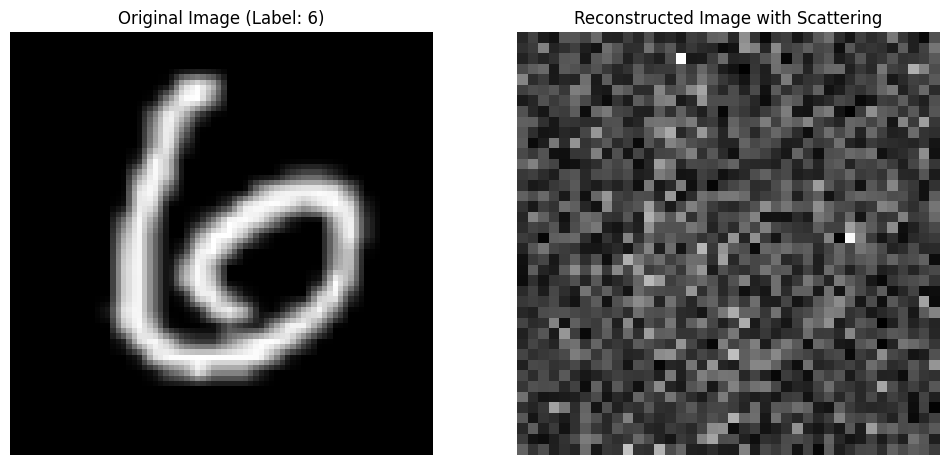

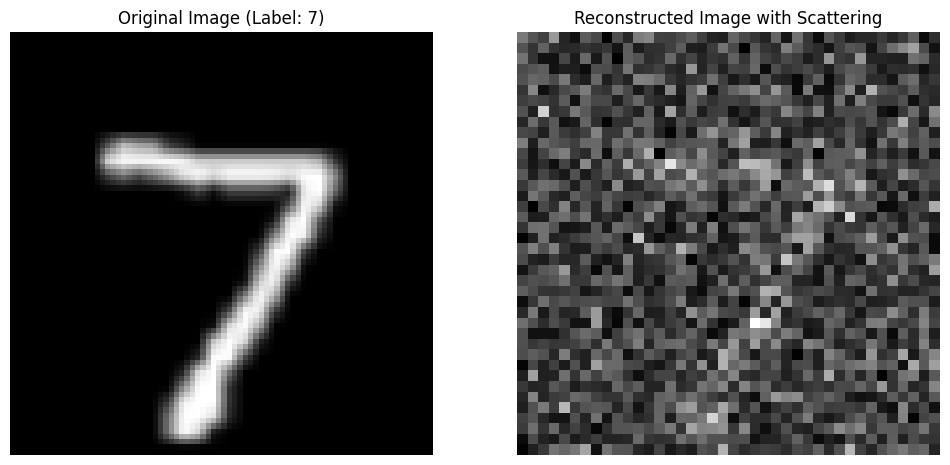

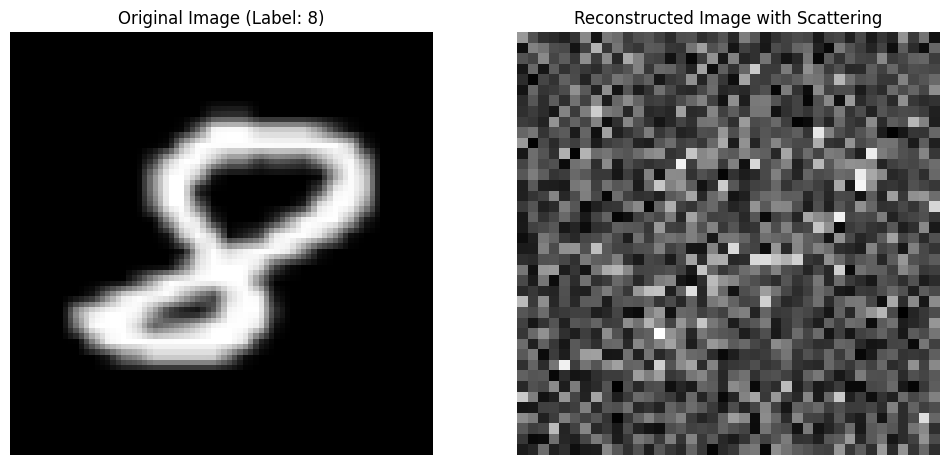

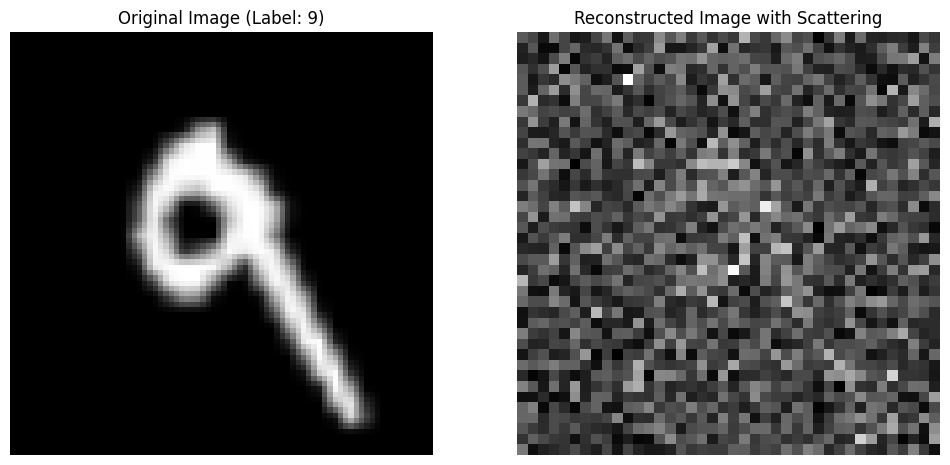

Time taken: 13.967283248901367


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torchvision import datasets, transforms
import cv2
import time

# 필요한 함수들 정의 (zernfun, gen_aberration 등)
# [여기에 zernfun과 gen_aberration 함수 코드를 그대로 복사합니다.]

# [00] Data options
full_opt = 1  # 1600(1), 1264(0)
basis = 'kx'  # kk, kx, rr

target_opt = 'lm'

abin_cpx = 'non'  # rand, non, exrand, (fix)
about_cpx = 'non'
about_fact = 10
abin_fact = 10

comp_opt = 'reim'  # angle, reim

sc_opt = 1  # scattering off(0)/on(1)
MS = 10  # 스캐터링 강도 조절
SM = 1 / MS  # single/multi intensity ratio

# [0] Parameters setup

NAsz = 20  # radius of pupil [pixel]
matsz = 4 * NAsz  # [pixel]

lamb = 0.8  # wavelength [um]
dx = lamb / 0.4 / 2  # NA resolution
xtick = dx * np.arange(1, matsz + 1) / 2
xtick = xtick - np.mean(xtick)

dk = 2 * 2 * np.pi / dx  # maximum k radius
ktick = dk / matsz * np.arange(1, matsz + 1)
ktick = ktick - np.mean(ktick)

xx, yy = np.meshgrid(np.arange(1, matsz + 1), np.arange(1, matsz + 1))
rr = (xx - np.mean(xx)) + 1j * (yy - np.mean(yy))

cmask = np.sqrt((xx - np.mean(xx)) ** 2 + (yy - np.mean(yy)) ** 2) / NAsz
cmask[cmask <= 1] = 1
cmask[cmask > 1] = 0

if full_opt == 1:
    nzind = np.arange(0, (2 * NAsz) ** 2)
else:
    cmask_crop = cmask[NAsz:3 * NAsz, NAsz:3 * NAsz]
    nzind = np.nonzero(cmask_crop)

start_time = time.time()

if comp_opt == 'reim':
    data_mat = np.zeros((2 * NAsz, 2 * NAsz, len(nzind) * 2))
    truth_mat = np.zeros((2 * NAsz, 2 * NAsz, 4))

# Prepare xin-kout (if basis is 'kx')
if basis == 'kx':
    xinkout = np.zeros(((2 * NAsz) ** 2, (2 * NAsz) ** 2), dtype=complex)
    for ii in range((2 * NAsz) ** 2):
        xin = np.zeros((2 * NAsz, 2 * NAsz), dtype=complex)
        xin.flat[ii] = 1
        tmp = np.fft.ifftshift(np.fft.fft2(np.fft.fftshift(xin)))
        xinkout[:, ii] = tmp.flatten()

# MNIST 데이터셋 로드
mnist_testset = datasets.MNIST(root='./data', train=False, download=True,
                               transform=transforms.Compose([transforms.ToTensor()]))

# 각 숫자(0~9)에 대한 첫 번째 이미지를 가져옵니다.
original_images = [None for _ in range(10)]

for img, label in mnist_testset:
    if original_images[label] is None:
        img_np = img.squeeze().numpy()
        original_images[label] = img_np
    if all(image is not None for image in original_images):
        break

# 이미지를 80x80 크기로 리사이즈합니다.
tobj_list = [cv2.resize(img, (80, 80), interpolation=cv2.INTER_LINEAR) for img in original_images]

# 각 이미지에 대해 처리
for idx, tobj in enumerate(tobj_list):
    # Continue with the rest of the computation
    xx, yy = np.meshgrid(np.arange(1, 4 * NAsz + 1), np.arange(1, 4 * NAsz + 1))
    re = 2
    cmask2 = np.sqrt((xx - np.mean(xx)) ** 2 + (yy - np.mean(yy)) ** 2) / (re * NAsz)
    cmask2[cmask2 <= 1] = 1
    cmask2[cmask2 > 1] = 0

    target = np.fft.fftshift(np.fft.fft2(tobj))

    ktarget = target * cmask  # r=40 mask
    ktarget = ktarget[NAsz:3 * NAsz, NAsz:3 * NAsz]

    xtarget = np.fft.ifft2(np.fft.ifftshift(target))

    # Generate kin-kout matrix
    kxtmp, kytmp = np.meshgrid(np.arange(-NAsz, NAsz), np.arange(-NAsz, NAsz))
    kx = kxtmp.flatten()
    ky = kytmp.flatten()
    n1 = (2 * NAsz) ** 2

    Smat = np.zeros((n1, n1), dtype=complex)

    for ii in range(n1):
        tmp = np.roll(np.roll(target, int(kx[ii]), axis=0), int(ky[ii]), axis=1) * cmask
        tmp = tmp[NAsz:3 * NAsz, NAsz:3 * NAsz]
        Smat[:, ii] = tmp.flatten()

    # Create input/output pupil function matrix
    sz = 2 * NAsz
    kx2, ky2 = np.meshgrid(np.arange(1, sz + 1), np.arange(1, sz + 1))
    kc = 20.5  # sz / 2 + 1
    NA_mask = (kx2 - kc) ** 2 + (ky2 - kc) ** 2 < NAsz ** 2
    roi_NA = np.arange(kc - NAsz, kc + NAsz)
    k_index = np.nonzero(NA_mask)

    ipf = np.zeros((2 * NAsz, 2 * NAsz), dtype=complex)
    opf = np.zeros((2 * NAsz, 2 * NAsz), dtype=complex)

    # Aberration 설정
    if abin_cpx == 'rand':
        abin_fact = 10 + 50 * np.random.rand()  # degree of aberration (10~60)
        ab_phase_map, z_coeff = gen_aberration(NA_mask, NAsz, 50, int(abin_fact))
        ipf[k_index] = np.exp(1j * ab_phase_map[k_index])
    elif abin_cpx == 'non':
        ipf[NA_mask] = 1.0  # no aberration

    if about_cpx == 'rand':
        about_fact = 10 + 50 * np.random.rand()  # degree of aberration (10~60)
        ab_phase_map_opf, z_coeff_opf = gen_aberration(NA_mask, NAsz, 50, int(about_fact))
        opf[k_index] = np.exp(1j * ab_phase_map_opf[k_index])
    elif about_cpx == 'non':
        opf[NA_mask] = 1.0  # no aberration

    # Apply pupil functions
    ipf_flat = ipf.flatten()
    opf_flat = opf.flatten()

    Smat = (opf_flat[:, np.newaxis]) * Smat * (ipf_flat[np.newaxis, :])

    kxmat = Smat
    kxmat = kxmat[:, nzind]

    if basis == 'kx':
        kxmat = kxmat @ xinkout

    if basis == 'rr':
        kxmat = kxmat @ kxmat.T

    if sc_opt == 1:
        chan = kxmat.shape[0]
        Mmat = np.random.randn(chan, chan) + 1j * np.random.randn(chan, chan)

        IM = np.mean(np.sum(np.abs(Mmat) ** 2))
        IS = np.mean(np.sum(np.abs(kxmat) ** 2))

        mat = kxmat * np.sqrt(IM / IS * SM) + Mmat
        kxmat = mat[:, nzind]
    else:
        kxmat = kxmat[:, nzind]

    # 복소수 데이터 복원
    num_channels = kxmat.shape[1]

    complex_image = np.zeros((2 * NAsz, 2 * NAsz), dtype=complex)

    for i in range(num_channels):
        complex_image += kxmat[:, i].reshape(2 * NAsz, 2 * NAsz)

    # 역변환하여 이미지 복원
    reconstructed_image = np.fft.ifft2(complex_image)

    # 실수부를 취하고 정규화
    reconstructed_magnitude = np.abs(reconstructed_image)
    reconstructed_magnitude /= np.max(reconstructed_magnitude)

    # 원본 이미지와 복원된 이미지 시각화
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(tobj, cmap='gray')
    plt.title(f'Original Image (Label: {idx})')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_magnitude, cmap='gray')
    plt.title('Reconstructed Image with Scattering')
    plt.axis('off')

    plt.show()

end_time = time.time()
print("Time taken:", end_time - start_time)
